<h1>Research Question</h1>
Can we reliably predict a county's electric vehicle (EV) registrations based off of vehicles' model year, vehicle type, electric range, income, and population in Washington State?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import duckdb

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing

import statsmodels.api as sm  # Optional for detailed statistical analysis

## Data Description
Electric Vehicle Registration Dataset:
We are using a dataset that shows the Battery Electric Vehicles (BEVs) and Plug-in Hybrid Electric Vehicles (PHEVs) that are currently registered through Washington State Department of Licensing (DOL). It provides key information about vehicle registrations, tax exemptions, and eligibility criteria for clean alternative fuel vehicles, and is updated regularly, with the monthly vehicle count subject to changes due to county assignment processes during registration. A Battery Electric Vehicle (BEV) is an all-electric vehicle using one or more batteries to store the electrical energy that powers the motor and is charged by plugging the vehicle in to an electric power source. A Plug-in Hybrid Electric Vehicle (PHEV) is a vehicle that uses one or more batteries to power an electric motor; uses another fuel, such as gasoline or diesel, to power an internal combustion engine or other propulsion source; and is charged by plugging the vehicle in to an electric power source.

The dataset consists of several columns representing various attributes related to each electric vehicle, including: VIN: Vehicle Identification Number (the first 10 characters; vehicles can have same or similar first 10 characters for their VIN); County: The county where the vehicle is registered; City: The city where the vehicle is registered; State: The state (WA for Washington); Postal Code: The postal code of the registration; Model Year: The year the vehicle model was manufactured; Make: The manufacturer brand of the vehicle; Model: The model of the vehicle. Each row in the dataset describes a specific electric vehicle that is registered in Washington State. Data relating to individual's electric vehicle registrations were utilized. However, there is no indication whether the people were aware of their data being used in this dataset. The Washington State Department of Licensing funded the creation of the original dataset. tThe author of the Kaggle dataset did not do any preprocessing, as the data was taken directly from Washington State Department of Licensing's datasets.

Kaggle Link: https://www.kaggle.com/datasets/sahirmaharajj/electric-vehicle-population
Official Link: https://data.wa.gov/Transportation/Electric-Vehicle-Population-Data/f6w7-q2d2/about_data

Median Household Income Dataset:
This dataset contains the median income for each county from 1989 to 2023. The dataset was created to display the median income for each county in Washington State. Each row in the dataset represents a county in Washington State. Each column in the dataset represents a year from 1989 to 2023. The estimation for median income for each county relies on both 1990 and 2000 census data. The estimates are also based on past relationships between available socioeconomic data and county-level median household income. The dataset's data might differ from other median household income data developed from the Office of Financial Management's State Population Survey, Bureau of the Census surveys, or other sources, indicating this dataset might not take into account survey's responses. Therefore these responses might not have been recorded. The data is from the Washington State Office of Financial Management. Census data were involved, indicating data of people living in Washington State were involved. However, there is no indication whether the people were aware of their data being used in this dataset. The website did not indicate any preprocessing was done. The website also does not indicate who funded the dataset.
Official Link: https://ofm.wa.gov/washington-data-research/economy-and-labor-force/median-household-income-estimates

Population Dataset:
This dataset contains the population for each county in Washington State. The dataset was created to display the population for each county. The data is taken from data.cov, an offiical website of the United States government. Each row of the dataset either represents Washington State, a specific county, or a specific city within a county. There are columns, County, to represent the county the specific county or city is a part of. There is a column named Jurisdiction that represents the governing authority, region, or administrative division. The website did not indicate any preprocessing was done. The website does not indicate who funded the creation of the dataset. The data is estimated using actual census data from both easlier and later censuses. Census data were involved, indicating data of people living in Washington State were involved. However, there is no indication whether the people were aware of their data being used in this dataset.
Official Link: https://catalog.data.gov/dataset/waofm-april-1-population-by-state-county-and-city-1990-to-present

## Data Cleaning

For the electric vehicle registration dataset, we moved column '2020 Census Tract' and 'Vehicle Location' since these columns would not be needed for our analysis. We deleted any rows that had missing data, so it does not affect our data analysis. 

In [2]:
df = pd.read_csv('Combined_Data.csv', encoding='ISO-8859-1')
print(df.shape)
df.head()

(77114, 17)


,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Electric Utility,income_2023,population_2023
0,5YJYGDEE1L,King,Seattle,WA,98122.0,2020,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,291,0,37.0,125701579,CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),119926.0,2347800.0
1,5YJSA1E4XK,King,Seattle,WA,98109.0,2019,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,270,0,36.0,156773144,CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),119926.0,2347800.0
2,5YJSA1E27G,King,Issaquah,WA,98027.0,2016,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,210,0,5.0,165103011,PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),119926.0,2347800.0
3,3FA6P0SU8H,Thurston,Yelm,WA,98597.0,2017,FORD,FUSION,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,21,0,2.0,122057736,PUGET SOUND ENERGY INC,91522.0,303400.0
4,1N4AZ0CP2D,Yakima,Yakima,WA,98903.0,2013,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,75,0,14.0,150126840,PACIFICORP,65167.0,261200.0


In [3]:
aggregated_df = duckdb.sql("""
    SELECT 
        County,
        COUNT(*) AS "Total EV Count",  -- Total count of all EVs in the county
        AVG("Electric Range") AS "Average Electric Range", -- Average Electric Range in the county
        AVG("Model Year") AS "Average Model Year", -- Average EV Model Year in the county
        MODE("Make") AS "Popular Brand", -- Most popular EV Brand in the county
        MODE("Model") AS "Popular Model", -- Most popular EV model in the county
        MODE("Electric Vehicle Type") AS "Popular EV Type", -- Most popular EV type in the county (BEV or PHEV)
        SUM(CASE WHEN "Electric Vehicle Type" = 'Battery Electric Vehicle (BEV)' THEN 1 ELSE 0 END) AS "BEV Count",  -- Count of BEVs
        SUM(CASE WHEN "Electric Vehicle Type" = 'Plug-in Hybrid Electric Vehicle (PHEV)' THEN 1 ELSE 0 END) AS "PHEV Count",  -- Count of PHEVs
        AVG("income_2023") AS "Median Income",  -- Median income in the county
        AVG("population_2023") AS "Population",  -- Population in the county
        -- Calculating BEV proportion directly within the query
        SUM(CASE WHEN "Electric Vehicle Type" = 'Battery Electric Vehicle (BEV)' THEN 1 ELSE 0 END) * 1.0 / COUNT(*) AS "BEV Proportion"  -- Proportion of BEVs
    FROM df
    GROUP BY County
    ORDER BY County ASC
""").df()
aggregated_df.head()

,County,Total EV Count,Average Electric Range,Average Model Year,Popular Brand,Popular Model,Popular EV Type,BEV Count,PHEV Count,Median Income,Population,BEV Proportion
0,Adams,19,131.842105,2018.105263,TESLA,MODEL 3,Battery Electric Vehicle (BEV),10.0,9.0,64498.0,21200.0,0.526316
1,Alameda,2,131.000000,2020.000000,TESLA,MODEL 3,Battery Electric Vehicle (BEV),1.0,1.0,NaN,NaN,0.500000
2,Albemarle,2,211.500000,2016.000000,TESLA,MODEL 3,Battery Electric Vehicle (BEV),2.0,0.0,NaN,NaN,1.000000
3,Alexandria,2,326.000000,2020.000000,TESLA,MODEL S,Battery Electric Vehicle (BEV),2.0,0.0,NaN,NaN,1.000000
4,Allen,2,121.500000,2017.500000,CHRYSLER,PACIFICA,Plug-in Hybrid Electric Vehicle (PHEV),1.0,1.0,NaN,NaN,0.500000


In [4]:
aggregated_df = aggregated_df.dropna()
aggregated_df.head()

,County,Total EV Count,Average Electric Range,Average Model Year,Popular Brand,Popular Model,Popular EV Type,BEV Count,PHEV Count,Median Income,Population,BEV Proportion
0,Adams,19,131.842105,2018.105263,TESLA,MODEL 3,Battery Electric Vehicle (BEV),10.0,9.0,64498.0,21200.0,0.526316
7,Asotin,41,89.414634,2018.975610,TOYOTA,WRANGLER,Plug-in Hybrid Electric Vehicle (PHEV),17.0,24.0,67820.0,22650.0,0.414634
10,Benton,1120,125.328571,2018.716964,TESLA,MODEL 3,Battery Electric Vehicle (BEV),576.0,544.0,87992.0,215500.0,0.514286
21,Chelan,510,142.231373,2018.533333,TESLA,LEAF,Battery Electric Vehicle (BEV),330.0,180.0,84430.0,81500.0,0.647059
23,Clallam,573,110.722513,2018.186736,CHEVROLET,LEAF,Battery Electric Vehicle (BEV),299.0,274.0,68924.0,78075.0,0.521815


## Pre Registration Statements
### Statement 1
**Hypothesis:** Counties with a higher density of BEVs (Battery Electric Vehicles) relative to other types of EVs have higher total EV registrations.

**Analysis:** We will calculate the proportion of BEVs among all EVs for each county. Then, we will perform a linear regression with the BEV proportion (for each county) as the input variable and the total EV registrations (for each county) as the output. The goal is to test whether the coefficient for BEV proportion indicates a meaningful link between BEV density and overall EV registrations within each county. We chose linear regression because it can detect direct correlations between BEV popularity and overall adoption trends. We will test whether BEV > 0. If it is significantly positive, then it indicates that the counties with higher BEV proportion tend to have more total EV registrations. Additionally, if a relationship exists, it could inform further investigation into socioeconomic or geographic factors that may affect EV adoption rates.

In [5]:
# Remove rows where BEV Proportion or Total EV Count is zero or null (to avoid issues in regression)
ev_density_by_county = aggregated_df.dropna(subset=["BEV Proportion", "Total EV Count"])
ev_density_by_county = aggregated_df[aggregated_df["Total EV Count"] > 0]

# Define independent variable (BEV Proportion) and dependent variable (Total EV Count)
X = ev_density_by_county["BEV Proportion"]
y = ev_density_by_county["Total EV Count"]

# Add a constant to the independent variable for the intercept term in the regression model
X = sm.add_constant(X)

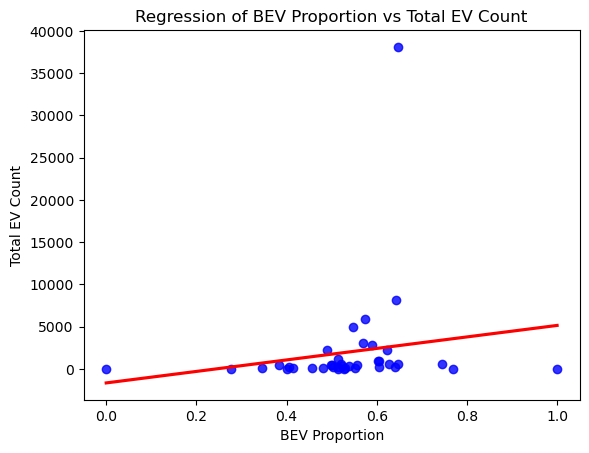

In [6]:
sns.regplot(x="BEV Proportion", y="Total EV Count", data=ev_density_by_county, 
            scatter_kws={'color': 'blue'}, line_kws={'color': 'red'}, 
            ci=None)  
plt.xlabel("BEV Proportion")
plt.ylabel("Total EV Count")
plt.title("Regression of BEV Proportion vs Total EV Count")

plt.show()

#### Null and Alternative Hypotheses
Null Hypothesis ($H_0$): The coefficient of BEV Proportion is equal to 0.
This implies that there is no significant relationship between the proportion of Battery Electric Vehicles (BEVs) in a county and the total number of EV registrations.

Alternative Hypothesis ($H_A$): The coefficient of BEV Proportion is not equal to 0.
This implies that there is a significant relationship between the proportion of BEVs in a county and the total number of EV registrations.




In [7]:
# Perform the linear regression
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         Total EV Count   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.062
Date:                Thu, 21 Nov 2024   Prob (F-statistic):              0.309
Time:                        20:43:45   Log-Likelihood:                -394.81
No. Observations:                  39   AIC:                             793.6
Df Residuals:                      37   BIC:                             796.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -1672.3873   3672.674     -0.

### Interpretation

There is no statistically significant relationship between the proportion of BEVs (Battery Electric Vehicles) in a county and the total EV registrations. According to the regression, for every 1-unit increase in BEV proportion (e.g., moving from 50% BEVs to 100% BEVs), the total number of EV registrations increases by approximately 329 vehicles.

### Predictions
When BEV Proportion = 0, 
Total EV Count = 351.35 + 329 $\cdot$ (BEV Proportion) = 351.35 + 329.38 $\cdot$ 0 = 351.35
This suggests that a country with no BEVs would still have 351 EV registrations. 

When BEV Proportion = 1, 
Total EV Count = 351.35 + 329 $\cdot$ (BEV Proportion) = 351.35 + 329.38 $\cdot$ 1 = 680.73
This suggests that a county where all registered EVs are BEVs is expected to have about 681 total EV registrations.


### Potential Oddities
The coefficient for BEV Proportion is not statistically significant ($p = 0.631$), meaning the relationship may not be reliable.  
The model may predict fractional EV registrations (e.g., 0.5 or 2.3 EVs), which is not realistic since EV registrations must be whole numbers.  
Counties with very high BEV proportions (e.g., 100%) might still have relatively few total EV registrations due to small population sizes, making the relationship appear artificially strong or weak depending on the scale of the data.  
The model does not account for counties with zero EV registrations, even if they have a non-zero BEV proportion.  
The relationship assumes linearity with may oversimplify real-world trends in EV adoption.

### Statistical Significance

P-value: 0.631: The intercept is not statistically significant because it is much greater than the common significance threshold (0.05), meaning we cannot reject the null hypothesis. There is no strong evidence to suggest that the BEV Proportion is significantly associated with Total EV Count.

The R-squared is 0.002, meaning that only 0.2% of the variation in Total EV Count is explained by the BEV Proportion. This indicates a very poor model fit, suggesting that BEV Proportion alone is not a good predictor of Total EV Count

The 95% confidence interval for the BEV Proportion coefficient is [-1024.716, 1683.471]. This wide interval indicates high uncertainty about the true effect of BEV proportion, and the interval includes 0, further supporting the lack of statistical significance.

The high p-value, low R-squared value, and wide confidence interval suggest no statistically significant relationship between BEV Proportion and total EV registrations. The model does not provide strong evidence to support the hypothesis.

We fail to reject the null hypothesis, meaning there is no evidence that the proportion of BEVs is significantly associated with higher total EV registrations. This indicates that BEV density alone is not a reliable predictor of EV registrations in counties.

## Pre Registration Statements
### Statement 2
**Hypothesis:** Counties with higher median incomes are correlated with a greater number of registered electric vehicles.

**Analysis:** We will combine EV registration by county and the median income by county from the median income dataset. Where each row represents a different county, we run a linear regression for median income in 2023 as input and the number of registered electric vehicles as output. Because the coefficient can contain signs to indicate a positive or negative relationship between the two variables, we will test whether income  0. If it is significantly positive, then it indicates that high-income countries tend to have more EVs. We will also evaluate the R-squared value to understand how much of the variation in EV registrations is explained by median income and other factors included in the model.

In [8]:
# Filter for non-null data
filtered_df = aggregated_df.dropna(subset=["Median Income", "Population"]).copy()
filtered_df["EVs per 1000"] = (filtered_df["Total EV Count"] / filtered_df["Population"]) * 1000
filtered_df.head()

,County,Total EV Count,Average Electric Range,Average Model Year,Popular Brand,Popular Model,Popular EV Type,BEV Count,PHEV Count,Median Income,Population,BEV Proportion,EVs per 1000
0,Adams,19,131.842105,2018.105263,TESLA,MODEL 3,Battery Electric Vehicle (BEV),10.0,9.0,64498.0,21200.0,0.526316,0.896226
7,Asotin,41,89.414634,2018.975610,TOYOTA,WRANGLER,Plug-in Hybrid Electric Vehicle (PHEV),17.0,24.0,67820.0,22650.0,0.414634,1.810155
10,Benton,1120,125.328571,2018.716964,TESLA,MODEL 3,Battery Electric Vehicle (BEV),576.0,544.0,87992.0,215500.0,0.514286,5.197216
21,Chelan,510,142.231373,2018.533333,TESLA,LEAF,Battery Electric Vehicle (BEV),330.0,180.0,84430.0,81500.0,0.647059,6.257669
23,Clallam,573,110.722513,2018.186736,CHEVROLET,LEAF,Battery Electric Vehicle (BEV),299.0,274.0,68924.0,78075.0,0.521815,7.339097


Text(0.5, 1.0, 'Average Income vs. Total EV Count for Counties')

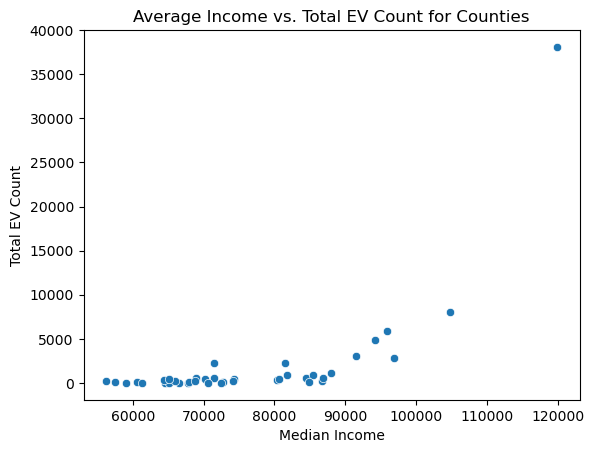

In [9]:
# Scatter plot to compare income and total EV Count for each county
sns.scatterplot(x='Median Income', y = 'Total EV Count', data = filtered_df)
plt.title('Average Income vs. Total EV Count for Counties')

From the scatterplot, we can tell that as average increases, the total EV count does tend to increase too. However counties with average income from 60,000 to 90,000 tends to have similar total EV counts. Counties with income higher than 90,000 tends to have more EV registrations, especially with the county that has an average income of 120,000. This county is Kings County which has one of the highest population count in Washington state, too. This can also indicate that population might play a role in EV registrations count, too.

In [10]:
# Linear regression
X = filtered_df["Median Income"].values.reshape(-1,1)
y = filtered_df["Total EV Count"].values

model = LinearRegression()
model.fit(X, y)

# Make predictions
y_pred = model.predict(X)

r2 = r2_score(y, y_pred)
print(f"R-squared: {r2:.2f}")

print(f"Coefficient for Median Income: {model.coef_[0]:.2f}")
print(f"Intercept: {model.intercept_:.2f}")

R-squared: 0.45
Coefficient for Median Income: 0.30
Intercept: -20691.03


The R-square value indicates that 45% of the variation in Total EV Count can be explained by Average Income alone. The relatively modest value indicates that other factors may also play a significant role. The coefficient implies that for every 1 dollar increase in Average Income, the Total EV Count increases by 0.30 vehicles. The intercept represents the predicted Total EV Count when Average Income = 0 dollar. This value doesn't make sense practically (as no county has $0 income), which might indicate limitations in predicting EV registrations for low income counties.

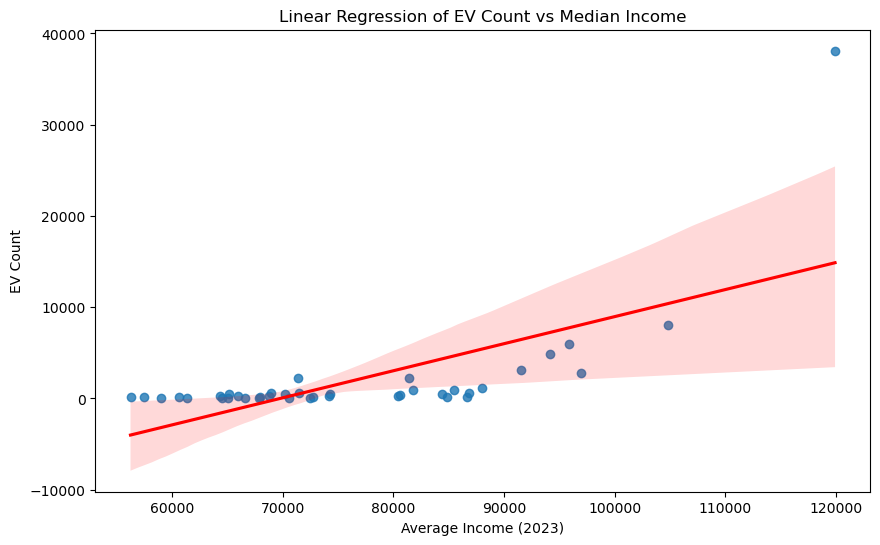

In [11]:
# Plot the regression
plt.figure(figsize=(10, 6))
sns.regplot(x=filtered_df["Median Income"], y=filtered_df["Total EV Count"], line_kws={"color": "red"})
plt.title("Linear Regression of EV Count vs Median Income")
plt.xlabel("Average Income (2023)")
plt.ylabel("EV Count")
plt.show()

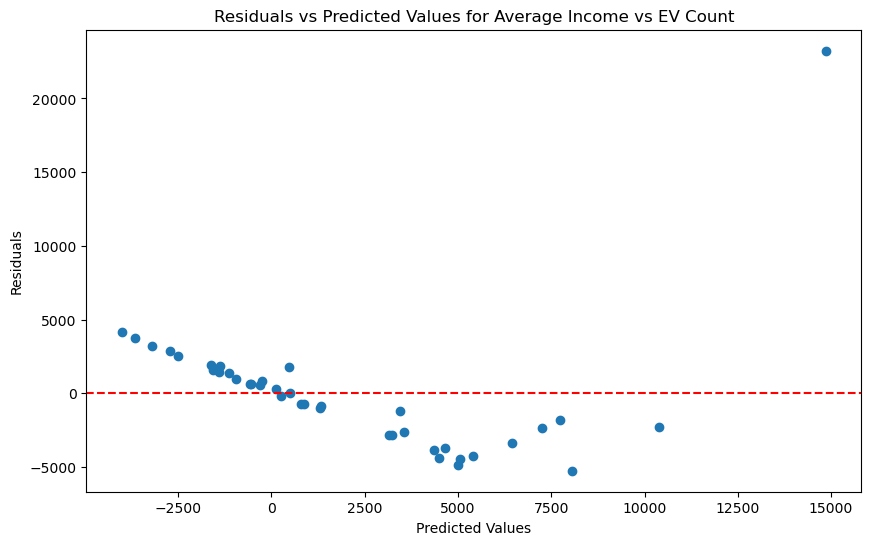

In [12]:
# Plot the residuals
residuals = y - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values for Average Income vs EV Count') 
plt.show()

The residual indicates some sort of heteroscedasticity. The model's predictions might not be as reliable. To address this, we can apply a log transformation to Total EV Count.

#### Null and Alternative Hypotheses
Null Hypothesis ($H_0$): The coefficient of Median Income is equal to 0.
This implies that there is no significant relationship between the median income of a county and the number of registered EVs.

Alternative Hypothesis ($H_A$): The coefficient of Median Income is not equal to 0.
This implies that there is a significant relationship between the median income of a county and the number of registered EVs.


In [13]:
X_with_const = sm.add_constant(X)  
ols_model = sm.OLS(y, X_with_const).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     29.94
Date:                Thu, 21 Nov 2024   Prob (F-statistic):           3.26e-06
Time:                        20:43:45   Log-Likelihood:                -383.80
No. Observations:                  39   AIC:                             771.6
Df Residuals:                      37   BIC:                             774.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.069e+04   4208.483     -4.917      0.0

### Interpretation

There is a statistically significant positive relationship between median income in a county and the total number of EVs registered. According to the regression, for every $1 increase in median income, the total EV count increases by approximately 0.3 vehicles.  

### Predictions
When average income = 0,   
Total EV Count = -20,681.03 + 0.3 $\cdot$ (Median Income) = -20,681.03 + 0.30 $\cdot$ 0 = -20,681.03
This is unrealistic since income and EV registrations cannot be negative, suggesting limitations in the model for low-income counties.

When average income = 100,000,     
Total EV Count =  -20,681.03 + 0.3 $\cdot$ (Median Income) = -20,681.03 + 0.30 $\cdot$ 100,000 = 9,308.97
This prediction suggests that counties with higher incomes (e.g., $100,000 average) could see significant EV registrations.

### Potential Oddities
The model predicts negative EV registrations for counties with very low median income, which is nonsensical and highlights a limitation of using linear regression in this context.  
The model predicts fractional EV registrations, which is unrealistic since EV registrations are discrete values.  
The model assumes a linear relationship between income and EV registrations. However, in reality, the relationship may plateau at very high incomes, as EV adoption might not increase indefinitely with wealth.

Overall, the model has limitations in capturing the complexities of EV adoption trends.

### Statistical Significance
The P-value for Median Income is <0.001. 
The p-value is much less than the commonly used significance threshold (e.g., 0.05). This allows us to reject the null hypothesis. There is strong evidence to suggest a statistically significant relationship between median income and total EV count.

The 95% confidence interval for the Median Income coefficient is [0.187, 0.406]. This interval does not include 0, which confirms the statistical significance of the result.

The R-squared value is 0.447, indicating that approximately 45% of the variation in EV registrations across counties is explained by median income. This indicates that median income is a moderately strong predictor of EV registrations.  
  
The low p-value, moderate R-squared value, and confidence interval suggest a statistically significant positive relationship between average income and EV registrations. Higher-income counties are more likely to have greater numbers of EVs, supporting the hypothesis.

We can reject the null hypothesis and conclude that there is strong evidence to support the hypothesis that counties with higher median incomes have more registered EVs. Median income is a significant predictor of EV registrations.

In [14]:
filtered_df["Log EV Count"] = np.log(filtered_df["Total EV Count"])
X = filtered_df[["Median Income"]]
y = filtered_df["Log EV Count"]

model = LinearRegression()
model.fit(X, y)

# Make predictions
y_pred = model.predict(X)

r2 = r2_score(y, y_pred)
print(f"R-squared: {r2:.2f}")

print(f"Coefficient for Median Income: {model.coef_[0]:.2f}")
print(f"Intercept: {model.intercept_:.2f}")

R-squared: 0.55
Coefficient for Median Income: 0.00
Intercept: -2.82


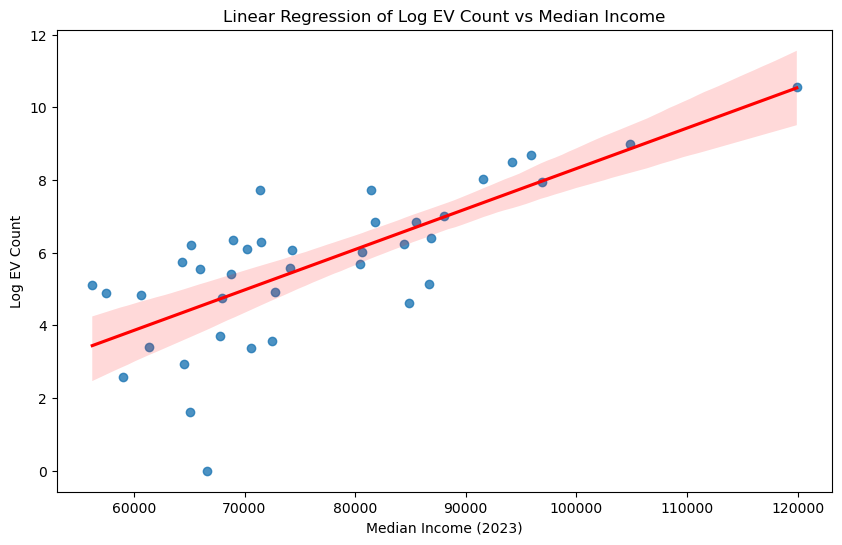

In [15]:
# Plot the regression
plt.figure(figsize=(10, 6))
sns.regplot(x=filtered_df["Median Income"], y=filtered_df["Log EV Count"], line_kws={"color": "red"})
plt.title("Linear Regression of Log EV Count vs Median Income")
plt.xlabel("Median Income (2023)")
plt.ylabel("Log EV Count")
plt.show()

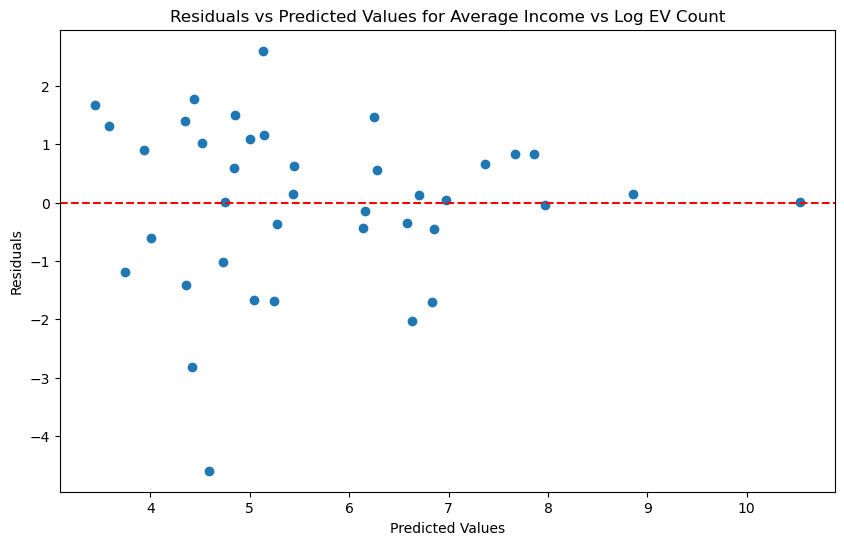

In [16]:
residuals = y - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values for Average Income vs Log EV Count') 
plt.show()

Compared to before log transformation, the variance of residuals is now more constant and scattered across the plot. This indicates that the log transformation successfully stabilized the variance. Most residuals are distributed fairly evenly around the red dashed line at y = 0, which means the model's predictions are unbiased on average. The linear regression plot indicates a positive relationship between Average Income and the log-transformed EV Count. Since the total EV count is log-transformed, this can indicate that the relationship between income and EV count is exponential. This can indicate that higher incomes are most likely to adopt EVs. 

### Population's Effect on EV Count
As seen from the scatterplot in the beginning of this section, population might play a role in EV registrations, too. Therefore, we plan to perform a multivariate regression to test whether average income and population plays a role in the number of EV registrations.

In [17]:
# Perform linear regression
filtered_df["Log EV Count"] = np.log(filtered_df["Total EV Count"])
X = filtered_df[["Median Income", "Population"]].values
y = filtered_df["Log EV Count"].values
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)
print(f"R-squared: {r2:.2f}")
coefficients = model.coef_
intercept = model.intercept_

print("Coefficients:")
for var, coef in zip(["Median Income", "Population"], coefficients):
    print(f"  {var}: {coef:.2f}")

print(f"Intercept: {intercept:.2f}")

R-squared: 0.59
Coefficients:
  Median Income: 0.00
  Population: 0.00
Intercept: -0.86


The R-squared value is 0.59, indicating that 59% of the variation in the log-transformed EV count based on the predictors (Average Income and Population). Average income's coefficient is 0.00 indictating that a 1-unit increase in Average Income (e.g., $1) corresponds to a proportional change in EV Count that is effectively negligible. This suggests that income, on its own, has a very small effect on proportional changes in EV count when other factors (like population) are considered. Similarly, the coefficient of population is 0.00, indicating the effect of a 1-unit increase in Population (1 additional person) on proportional EV Count is negligible.

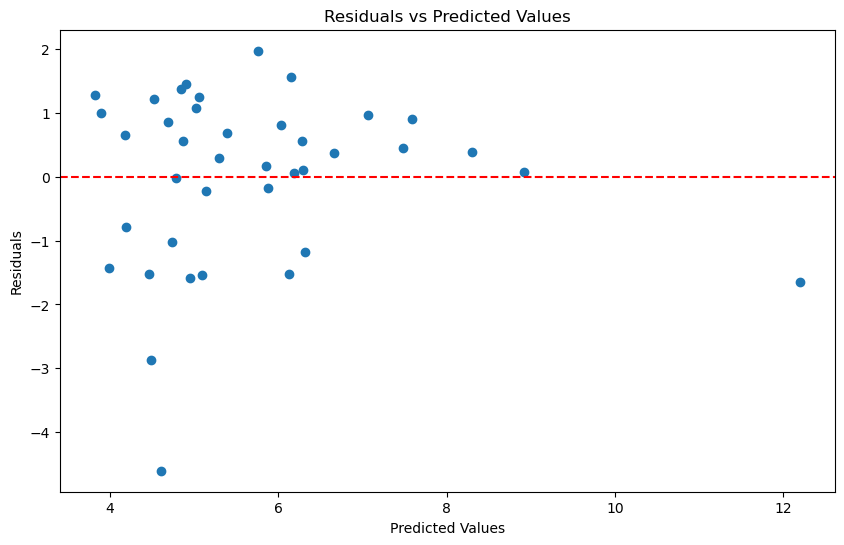

In [18]:
residuals = y - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values') 
plt.show()

The residual is more scattered, indicating there might not be any heteroscedasticity. Based on the values above, average income and population together might not be a good predictor for total EV registrations. We can utilize OLS Regression to obtain more insight.

### Overall Model Hypothesis

Null Hypothesis ($H_0$): The model with predictors (Average Income, Population) does not significantly explain variation in the total EV registrations. 

Alternative Hypothesis ($H_A$): The model with predictors (Average Income, Population) significantly explains variation in the total EV registrations.

In [19]:
# Define the predictors (independent variables)
X = filtered_df[["Median Income", "Population"]]

# Add a constant to the model (intercept term)
X = sm.add_constant(X)

# Define the target (dependent variable)
y = filtered_df["Log EV Count"]

# Fit the multivariate regression model
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           Log EV Count   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     25.42
Date:                Thu, 21 Nov 2024   Prob (F-statistic):           1.31e-07
Time:                        20:43:45   Log-Likelihood:                -66.546
No. Observations:                  39   AIC:                             139.1
Df Residuals:                      36   BIC:                             144.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.8617      1.675     -0.514

### Interpretation
The R-squared value is 0.585, indicating 58.5% of the variance in the log-transformed EV Count. This suggests that Average Income and Population together moderately explain the proportional changes in EV adoption across counties. The coefficient of Average Income is 8.207e-05 , suggesting that if average income is increase by $1, then we expect the total EV count to be mulitplied by e^(8.207e-05 ), which equals about 1. The p-value for average income is 0.001, which is statistically significant (p < 0.05), indicating that income has a meaningful positive impact on proportional EV adoption. On the other hand, for population, the p-value is 0.088 (p > 0.05), which is not statistically significant. After accounting for income, population does not strongly influence proportional EV adoption. The overall p-value is 0.610, suggesting that the model is not statistically signifcant. Therefore, we failed to reject the null hypothesis. Population and median income together does not play a huge role in predicting EV registrations. Next steps would be to potentially look at population individually.

## Multivariate Regression
Can we better predict the total number of EV registrations in a county using multiple predictors, including BEV Proportion, Average Model Year, and Average Electric Range?

### Overall Model Hypothesis

Null Hypothesis ($H_0$): The model with predictors (BEV Proportion, Average Model Year, Average Electric Range) does not significantly explain variation in the total EV registrations. 

Alternative Hypothesis ($H_A$): The model with predictors (BEV Proportion, Average Model Year, Average Electric Range) significantly explains variation in the total EV registrations.

In [20]:
# Define the predictors (independent variables)
X = aggregated_df[["BEV Proportion", "Average Model Year", "Average Electric Range"]]

# Add a constant to the model (intercept term)
X = sm.add_constant(X)

# Define the target (dependent variable)
y = aggregated_df["Total EV Count"]

# Fit the multivariate regression model
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         Total EV Count   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     1.924
Date:                Thu, 21 Nov 2024   Prob (F-statistic):              0.144
Time:                        20:43:45   Log-Likelihood:                -392.38
No. Observations:                  39   AIC:                             792.8
Df Residuals:                      35   BIC:                             799.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -1.04

### Interpretation
The model's R-squared value of 0.142 indicates that only 14.2% of the variation in total EV registrations is explained by these predictors, suggesting a weak overall fit. The p-value of the model in general is 0.05 (p = 0.05), indicating predictors collectively do not explain the variation in Total EV Count at a statistically significant level. We have failed to reject our null hypothesis. Individually, BEV Proportion has a significant positive coefficient (49,270.40, p = 0.035), implying that a higher proportion of BEVs strongly correlates with greater total EV registrations. In contrast, Average Model Year has a significant positive effect (coefficient = 5,179.70, p = 0.050), suggesting that newer average model years are associated with higher EV counts. However, Average Electric Range is not statistically significant (p = 0.154), indicating no strong evidence of its influence on total EV count. This indicates that unlike before where BEV proportion does not seem to play a role in EV registrations, when combined with model year and electric range, it holds some signficance.

In [21]:
# Perform linear regression
X = aggregated_df[["BEV Proportion", "Average Model Year", "Average Electric Range"]].values
y = aggregated_df["Total EV Count"].values
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)
print(f"R-squared: {r2:.2f}")
coefficients = model.coef_
intercept = model.intercept_

print("Coefficients:")
for var, coef in zip(["BEV Proportion", "Average Model Year", "Average Electric Range"], coefficients):
    print(f"  {var}: {coef:.2f}")

print(f"Intercept: {intercept:.2f}")

R-squared: 0.14
Coefficients:
  BEV Proportion: 49267.84
  Average Model Year: 5179.70
  Average Electric Range: -135.49
Intercept: -10463053.13


The R-squared value is 0.14, indicating that the model explains 14% of the variation in the Total EV Count. This is a relatively weak fit, suggesting that most of the variation in EV Count is not captured by these predictors. BEV proportion's coefficient is 49267.84, indicating that for every unit increase in BEV Proportion (e.g., from 0.5 to 0.6), Total EV Count increases by 49,267.84 units, holding other variables constant. Average Model Year's coefficient is 5179.90, indicating for every 1-year increase in Average Model Year (e.g., from 2018 to 2019), Total EV Count increases by 5,179.70 units, holding other variables constant. However, electric range's coefficient is -135.49, which is counterintutitive as higher electric range is typically considered an advantage for EV adoption. This result might suggest that other factors are more influential.

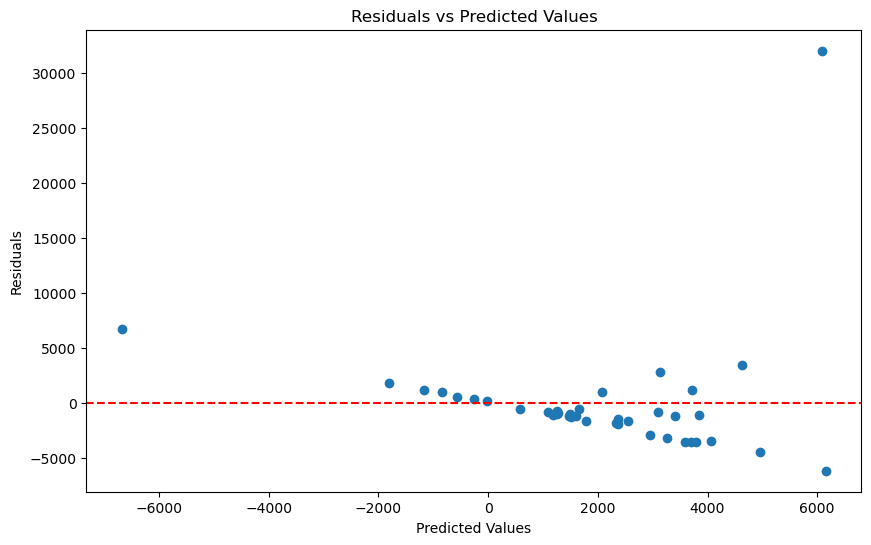

In [22]:
# Plot the residuals
residuals = y - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values') 
plt.show()

The residual indicates some sort of heteroscedasticity. The model's predictions might not be as reliable. To address this, we can apply a log transformation to Total EV Count.

In [23]:
# Linear Regression with Total EV Count log transformed
aggregated_df["Log EV Count"] = np.log(aggregated_df["Total EV Count"])
X = aggregated_df[["BEV Proportion", "Average Model Year", "Average Electric Range"]].values
y = aggregated_df["Log EV Count"]

model = LinearRegression()
model.fit(X, y)

# Make predictions
y_pred = model.predict(X)

r2 = r2_score(y, y_pred)
print(f"R-squared: {r2:.2f}")

print("Coefficients:")
for var, coef in zip(["BEV Proportion", "Average Model Year", "Average Electric Range"], coefficients):
    print(f"  {var}: {coef:.2f}")

print(f"Intercept: {intercept:.2f}")

R-squared: 0.46
Coefficients:
  BEV Proportion: 49267.84
  Average Model Year: 5179.70
  Average Electric Range: -135.49
Intercept: -10463053.13


The R-squared value of 0.46 indicates that 46% of the variability in the log-transformed Total EV Count is explained by these predictors, suggesting a moderate fit for the model. A one-unit increase in BEV Proportion (e.g., moving from 0.5 to 0.6) corresponds to a proportional increase in the Total EV Count by a factor of e^(49,267.84). This indicates a multiplicative growth effect, meaning that counties with higher BEV proportions experience exponential growth in EV registrations. A one-year increase in Average Model Year corresponds to a proportional increase in Total EV Count by a factor of e^(5,179.70). This highlights that counties with newer EV fleets tend to adopt EVs at an accelerating rate. On the other hand, electric range's coefficient is negative, suggesting that other factors are more influential.

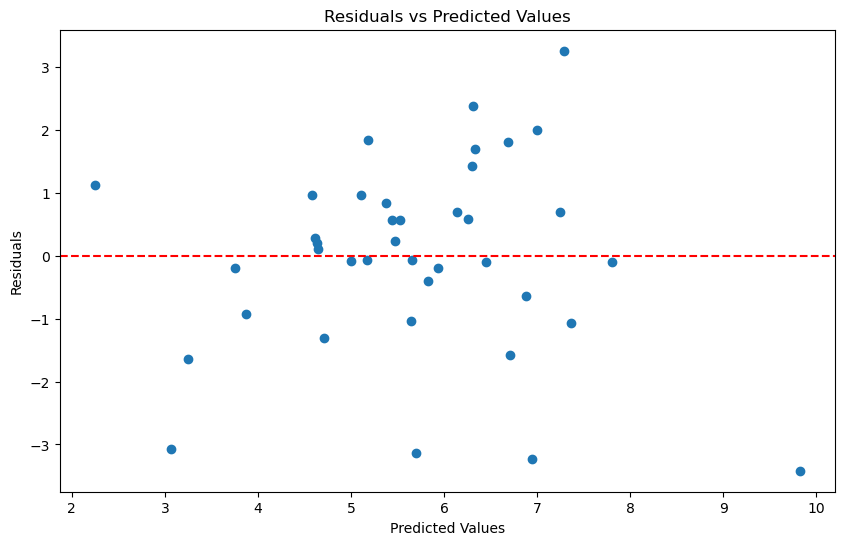

In [24]:
residuals = y - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values') 
plt.show()

In [25]:
# Define the predictors (independent variables)
X = aggregated_df[["BEV Proportion", "Average Model Year", "Average Electric Range"]]

# Add a constant to the model (intercept term)
X = sm.add_constant(X)

# Define the target (dependent variable)
y = aggregated_df["Log EV Count"]

# Fit the multivariate regression model
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           Log EV Count   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.416
Method:                 Least Squares   F-statistic:                     10.04
Date:                Thu, 21 Nov 2024   Prob (F-statistic):           6.45e-05
Time:                        20:43:45   Log-Likelihood:                -71.610
No. Observations:                  39   AIC:                             151.2
Df Residuals:                      35   BIC:                             157.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -2880

### Interpretation
The R-squared value of 0.463 indicates that 46.3% of the variability in the log-transformed EV Count is explained by these predictors, suggesting a moderate fit. Among the coefficients, BEV Proportion has a positive and significant relationship with the log-transformed EV Count, with a coefficient of 30.41 (p-value = 0.000), indicating that a one-unit increase in BEV Proportion results in a proportional increase in EV Count by a factor of e^(30.41), holding other variables constant. Average Model Year also has a positive coefficient of 1.43 (p-value = 0.044), meaning newer EV fleets are associated with a slight proportional increase in EV Count. Conversely, Average Electric Range has a negative coefficient of -0.12 (p-value = 0.000), showing a small but statistically significant inverse relationship with EV Count. The overall model is significant (p-value is 0.044, which is < 0.05), and the low p-values for individual predictors confirm their importance in explaining the variability in EV Count. However, the relatively moderate R-squared suggests additional factors not included in this model may also influence EV adoption.

## Summary of Results
The regression analysis for Pre-Registration 1 suggests that there is no significant relationship between the proportion of BEVs and the total EV registrations in a county. The p-value for the BEV Proportion coefficient (0.631) is too large to reject the null hypothesis, and the very low R-squared value indicates that BEV Proportion explains almost none of the variation in Total EV Count. Therefore, we conclude that BEV density is not a strong standalone predictor of overall EV registrations.
  
The regression analysis for Pre-Registration 2 demonstrates a positive relationship between median income and EV registrations. Counties with higher median incomes tend to register more EVs. The R-squared value indicates that median income accounts for a substantial proportion of the variation in EV registrations, although other factors likely contribute as well. This finding supports the hypothesis and suggests that income is an important factor influencing EV adoption trends. When population is added on with income, there does not seem to be a significant relationship between population + median income and EV registrations, indicating population might not play a role in EV registrations, though doing a linear regression between just population and EV registrations can tell us more.

In summary, while BEV density was not a significant factor in isolation, when combined with Model Year and Electric Range, it became a meaningful predictor in the context of the multivariate regression model. Additionally, median income also seems to be a meaningful predictor in EV registrations. This analysis underscores the complex interplay of vehicle type, technology, and region-specific factors in shaping EV adoption.

## Limitations
The regression model predicts fractional EV registrations, which is not realistic since registrations are discrete values.  
Counties with small populations or unique geographic conditions may skew the results. For example, a county with high BEV density but low total EV registrations due to a small population could distort the perceived relationship.  
The data represents a section in time, making it difficult to assess trends or causality. EV adoption patterns may evolve with new policies, technological advancements, or economic changes.

## Acknowledgements and Bibliography
Tools and Libraries: Python libraries including pandas, numpy, matplotlib, seaborn, statsmodels, and scikit-learn were used for data analysis and visualization.

Data Sources: The electric vehicle registration data was sourced from the Washington State Department of Licensing (DOL). Socioeconomic data was incorporated from publicly available datasets on county incomes and populations.

